# Introducción clasificación de imágenes.

Si en el tema anterior hemos procedido a crear código para poder clasificar elementos numéricos, en el tema actual vamos a proceder a hacer una clasificación similar, pero en este caso con imágenes.

Lo primero que hacemos, es importar los paquetes que necesitamos

In [2]:
#!pip install torchvision

In [3]:
import random
import numpy as np
from PIL import Image
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, \
        WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize,\
ToPILImage, RandomHorizontalFlip, Resize
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from stepbystep.v0 import StepByStep

ModuleNotFoundError: No module named 'tensorboard'

Vamos a definir en el bloque siguiente una función que nos servirá para generar las imágenes con las que se va a trabajar

In [71]:
def gen_img(start, target, fill=1, img_size=10):
    # Generates empty image
    img = np.zeros((img_size, img_size), dtype=float)

    start_row, start_col = None, None

    if start > 0:
        start_row = start
    else:
        start_col = np.abs(start)

    if target == 0:
        if start_row is None:
            img[:, start_col] = fill
        else:
            img[start_row, :] = fill
    else:
        if start_col == 0:
            start_col = 1
        
        if target == 1:
            if start_row is not None:
                up = (range(start_row, -1, -1), 
                      range(0, start_row + 1))
            else:
                up = (range(img_size - 1, start_col - 1, -1), 
                      range(start_col, img_size))
            img[up] = fill
        else:
            if start_row is not None:
                down = (range(start_row, img_size, 1), 
                        range(0, img_size - start_row))
            else:
                down = (range(0, img_size - 1 - start_col + 1), 
                        range(start_col, img_size))
            img[down] = fill
    
    return 255 * img.reshape(1, img_size, img_size)


def generate_dataset(img_size=10, n_images=100, binary=True, seed=17):
    np.random.seed(seed)

    starts = np.random.randint(-(img_size - 1), img_size, size=(n_images,))
    targets = np.random.randint(0, 3, size=(n_images,))
    
    images = np.array([gen_img(s, t, img_size=img_size) 
                       for s, t in zip(starts, targets)], dtype=np.uint8)
    
    if binary:
        targets = (targets > 0).astype(int)
    
    return images, targets

Las imágenes que se generan con el código anterior, son muy simples, pero nos sirven para mostrar el procedimiento de clasificación de este tipo de elementos. Consisten en imágenes que tienen el fondo negro y después unas líneas blancas que están dibujadas sobre ese fondo negro. La clasificación que se va a hacer es la siguiente:

* Si la línea es diagonal, entonces toma valor 1 (clase positiva)

* Si la línea no es diagonal, entonces toma el valor 0 (clase negativa)

Vamos a generar de forma aleatoria un total de 300 imágenes cada una con un total de 5x5 pixeles

In [72]:
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

In [73]:
def plot_images(images, targets, n_plot=30):
    n_rows = n_plot // 6 + ((n_plot % 6) > 0)
    fig, axes = plt.subplots(n_rows, 6, figsize=(9, 1.5 * n_rows))
    axes = np.atleast_2d(axes)
    
    for i, (image, target) in enumerate(zip(images[:n_plot], targets[:n_plot])):
        row, col = i // 6, i % 6    
        ax = axes[row, col]
        ax.set_title('#{} - Label:{}'.format(i, target), {'size': 12})
        # plot filter channel in grayscale
        ax.imshow(image.squeeze(), cmap='gray', vmin=0, vmax=1)

    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.label_outer()

    plt.tight_layout()
    return fig

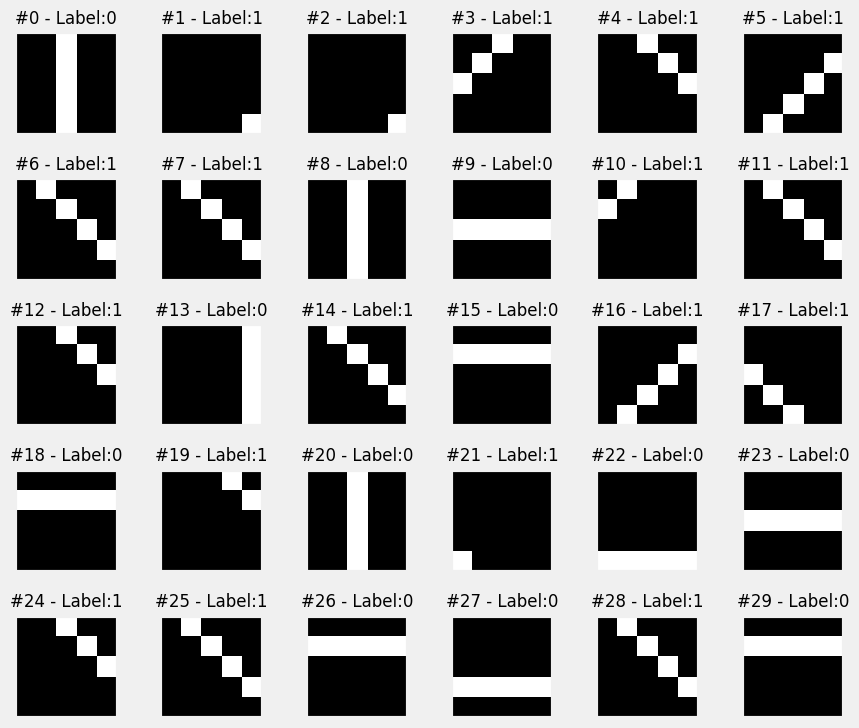

In [74]:
fig = plot_images(images, labels, n_plot=30)

Dado el escaso número de pixeles con los que trabajamos, existirán imágenes repetidas en el total de 300 que hemos generado,pero esto en principio no importa.

## Formación de imágenes para tensores.

En este apartado vamos a hacer un pequeño inciso sobre el formato que tienen las imágenes para poder trabajar sobre ellas con los tensores.

Para entrar en escena, vamos a crear a continuación tres imágenes de 5x5 pixeles, que está representado por una matriz de tamaño 5x5.

In [75]:
image_r = np.zeros((5, 5), dtype=np.uint8)
image_r[:, 0] = 255
image_r[:, 1] = 128

image_g = np.zeros((5, 5), dtype=np.uint8)
image_g[:, 1] = 128
image_g[:, 2] = 255
image_g[:, 3] = 128

image_b = np.zeros((5, 5), dtype=np.uint8)
image_b[:, 3] = 128
image_b[:, 4] = 255

In [76]:
image_r

array([[255, 128,   0,   0,   0],
       [255, 128,   0,   0,   0],
       [255, 128,   0,   0,   0],
       [255, 128,   0,   0,   0],
       [255, 128,   0,   0,   0]], dtype=uint8)

Tenemos en este caso tres representaciones de una figura en dos dimensiones lo que significa que se tiene una representación de la imagen en un canal simple. Los valores de la matriz varían desde 0 ( color negro) hasta el 255 (color blanco) y entre medias tendríamos las diferentes tonalidades de grises.

Veamos algunas representaciones de estas imágenes

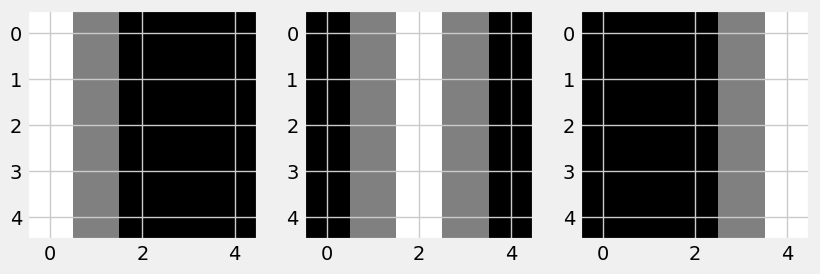

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(9, 10))
ax = axes[0]
ax.imshow(image_r.squeeze(), cmap='gray')

ax = axes[1]
ax.imshow(image_g.squeeze(), cmap='gray')

ax = axes[2]
ax.imshow(image_b.squeeze(), cmap='gray')

Cada una de las matrices anteriores podrían representar un color: rojo, verde y amarillo que al mezclarse darían lugar a los diferentes colores que podemos apreciar los humanos. La mezcla de estos colores, lo hariamos de la siguiente manera: 

In [78]:
image_rgb = np.stack([image_r, image_g, image_b], axis=2)
image_rgb

array([[[255,   0,   0],
        [128, 128,   0],
        [  0, 255,   0],
        [  0, 128, 128],
        [  0,   0, 255]],

       [[255,   0,   0],
        [128, 128,   0],
        [  0, 255,   0],
        [  0, 128, 128],
        [  0,   0, 255]],

       [[255,   0,   0],
        [128, 128,   0],
        [  0, 255,   0],
        [  0, 128, 128],
        [  0,   0, 255]],

       [[255,   0,   0],
        [128, 128,   0],
        [  0, 255,   0],
        [  0, 128, 128],
        [  0,   0, 255]],

       [[255,   0,   0],
        [128, 128,   0],
        [  0, 255,   0],
        [  0, 128, 128],
        [  0,   0, 255]]], dtype=uint8)

## Formato NCHW vs NHWC.

```{index} NCHW, NHWC
```

El significado de esta numenclatura es el siguiente:

* N: Representa el número de imágenes.

* C Representa el número de canales.

* H Representa la altura de la imagen (Height)

* W Representa la anchura de la imagen (Widht)

Esta notación es el acrónimo de lo que se espera en una entrada mini-batch.

Entonces:

* NCHW : (n.imagenes,canales,alto,ancho)
* NHWC : (n.imagenes,alto,ancho,canales)

Hay que tener en cuenta que el formato NCHW es el utilizado por PyTorch, NHWC lo utiliza NHWC  el <a href="https://pillow.readthedocs.io/en/stable/index.html" target="_blank"> paquete de imágenes PIL </a> usa el formato HWC.

Teniendo en cuenta todos estos conceptos, lógicamente las imágenes que hemos generado están en formato NCHW listas por lo tanto para poder ser usadas en PyTorch. Veamos pues la dimensión del conjunto de imágenes que hemos creado.

In [79]:
images.shape

(300, 1, 5, 5)

Es decir, tendriamos 300 imágenes de un solo canal, de 5x5. Veamos el contenido de una imagen

In [80]:
example = images[7]
example

array([[[  0, 255,   0,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0,   0, 255,   0],
        [  0,   0,   0,   0, 255],
        [  0,   0,   0,   0,   0]]], dtype=uint8)

O varias imágenes

In [81]:
images[5:7]

array([[[[  0,   0,   0,   0,   0],
         [  0,   0,   0,   0, 255],
         [  0,   0,   0, 255,   0],
         [  0,   0, 255,   0,   0],
         [  0, 255,   0,   0,   0]]],


       [[[  0, 255,   0,   0,   0],
         [  0,   0, 255,   0,   0],
         [  0,   0,   0, 255,   0],
         [  0,   0,   0,   0, 255],
         [  0,   0,   0,   0,   0]]]], dtype=uint8)

En todas estas imágenes, vemos que todas ellas tienen una línea diagonal, indicada por el valor 255 (color blanco). Supongamos que ahora queremos pasar una imagen al formato requerido por PIL (HWC), entonces para conseguir estos debemos usar el método *transpose* de numpy de las siguiente manera:

In [82]:
example_hwc = np.transpose(example,(1,2,0))
example_hwc.shape

(5, 5, 1)

In [83]:
example_hwc

array([[[  0],
        [255],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [255],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [255],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [255]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0]]], dtype=uint8)

## Torchvision.

 <a href="https://pillow.readthedocs.io/en/stable/index.html" target="_blank"> Esta librería </a> es parte del proyecto PyTorch y contiene data set populares, arquitectura de modelos, y transformaciones comunes de imágenes para computer vision.
 
 ### Datasets.
 
```{index} ImageFolder
``` 
 
 Muchos data set populares, como MNIST, ImageNet o CIFAR están incluidos en los dataset de PyTorch. Estos data set heredan de la clase *Dataset*, y en consecuencia se les puede aplicar *DataLoader* como ya se ha explicado en apartados anteriores.
 
 Hay un particular dataset sobre el que hay que pararse un poquito. Se trata de <a href="https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder"  target="_blank"> ImageFolder </a>, que es un dataset genérico que se puede utilizar con las propias imágenes del ususario. Este dataset se puede organizar en subcarpetas, cada una conteniendo imágenes de diversos temas.
 
 ### Modelos.
 
 PyTorch también incluye <a herf="https://pytorch.org/vision/stable/models.html" target="_blank"> diversos modelos ya entrenados </a>.
 
 Entre los muchos modelos que ya vienen en la instalación por defecto, se pueden encontrar algunos bien conocidos como Alexnet, VGG, ResNet.
 
 ### Transformadores.
 
 Se puede encontrar también un módulo que permite <a heref="https://pytorch.org/vision/stable/transforms.html" target="_blank"> hacer transformaciones de imágenes </a>. Este módulo es importante para hacer dos grupos de transformaciones:
 
 * Transformaciones sobre imágenes. (Hay un trasnformador para convertir entre imágenes PIL y tensores)
 
 * Trasnformaciones basadas en tensores.
 
 ```{index} ToPILmage, ToTensor
```
 
 Se pueden hacer transformaciones de tensor a PIL (ToPILImage), y de PIL a tensor (ToTensor) 
 
 Vamos a ver cómo poder convertir una imagen PIL, que es la que hemos obtenido antes y que se denomina *example_hwc* a un tensor de PyTorch. Lo hacemos de la siguiente manera

In [84]:
tensorizer = ToTensor() # Esta clase pasa a tensor la imagen con formato PIL
example_tensor = tensorizer(example_hwc)
example_tensor.shape

torch.Size([1, 5, 5])

In [85]:
# Veamos su contenido
example_tensor

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

Podemos observar que aquí también tenemos una imagen en diagonal, pero...no es lo mismo que teniamos en la imagen inicial, pues recordemos que aquella tenía de contenido lo siguiente

In [86]:
example

array([[[  0, 255,   0,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0,   0, 255,   0],
        [  0,   0,   0,   0, 255],
        [  0,   0,   0,   0,   0]]], dtype=uint8)

Es decir el valor 255 se ha convertido en 1. Esto es así porque por defecto esta transformación lo que ha hecho es escalar los valores, para que pasen a valer entre cero y uno.

Estas transformaciones modifican las imágenes de entrenamiento de muchas formas diferentes: girando, desplazando, volteando, recortando, desenfocando ampliarla, añadirle ruido, borrar partes de ella...

**Es lo que se llama aumento de datos**. Es una técnica inteligente para ampliar un conjunto de datos (aumentarlo) sin recoger más datos. En general, los modelos de aprendizaje profundo son muy ávidos de datos y requieren una gran cantidad de ejemplos para funcionar bien. Pero la recopilación de grandes conjuntos de datos suele ser difícil, y a veces imposible.

Para entender mejor lo anterior supongamos que tenemos una imagen de un perro. Si la giramos, sigue siendo un perro,
pero desde un ángulo diferente. En lugar de tomar dos fotos del perro, una desde cada ángulo, tomamos la imagen que ya tenemos y utilizamos el aumento de datos para simular muchos ángulos diferentes. No es lo mismo que la foto real, pero se acerca lo suficiente como para mejorar el rendimiento de nuestro modelo. 

Ni que decir tiene que el aumento de datos no es adecuado para todas las tareas: si se trata de realizar una detección de objetos es decir, detectar la posición de un objeto en una imagen, no debería hacer nada que cambie su posición, como voltear o desplazar. Sin embargo, añadir un poco de ruido también estaría bien.

### Transformaciones sobre imágenes

Para ver este apartado es necesario inicialmente tener una imagen y para ello veamos ahora cómo poder convertir un tensor a una imagen PIL. El código sería el siguiente

In [87]:
example_img = ToPILImage()(example_tensor)
print(type(example_img))

<class 'PIL.Image.Image'>


Como el valor obtenido es una imagen PIL podremos usar Matpltliib para hacer su representación gráfica.

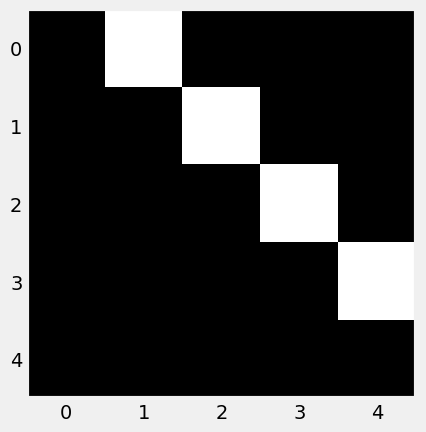

In [88]:
plt.imshow(example_img, cmap='gray')
plt.grid(False)

Son muchas las transformaciones que se pueden hacer sobre una imagen y que se pueden consultar en la documentación oficial de PyTorch, pero aquí vamos a ver un ejemplo sobre cómo poder utilizar estas herramientas.

Entre las transformaciones que nos ofrece pytorch están: Resize(), CenterCrop, GrayScale, RandomHorizontalFlip y RandomRotation.

Vamos a utilizar la transformación *RandomHorizontalFlip*. En este ejemplo no vamos a dejar nada aleatorio y lo que vamos a hacer es que la figura se gire por completo. Veamoslo

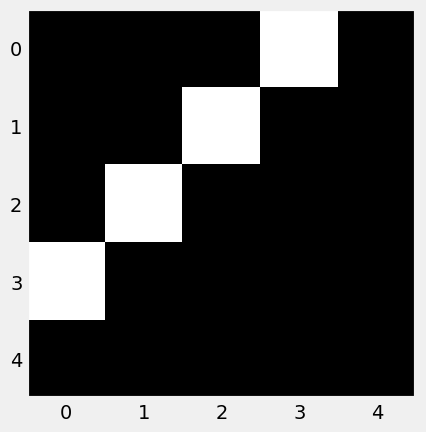

In [89]:
flipper = RandomHorizontalFlip(p=1.0)
flipped_img = flipper(example_img)

plt.imshow(flipped_img, cmap='gray')
plt.grid(False)

Como podemos ver es como si tuviéramos un eje vertical en el centro de la imagen y se hiciera girar esa imagen 180 grados alrededor de ese eje.

### Transformaciones sobre tensores.

Para el caso de transformaciones para tensores (a diferencia de las imágenes), tan sólo tenemos cuatro posibilidades:

1.- LinearTransformation

2.- Normalize

3.- RandomErasing

4.- ConvertImageDtype

Para ver el funcionamiento de estas transformaciones, vamos a pasar la imagen a un tensor

In [90]:
img_tensor = tensorizer(flipped_img)
img_tensor

tensor([[[0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

#### Transformación normalize.

La funcionalidad de esta transformación se <a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Normalize.html#torchvision.transforms.Normalize" target="_blank"> puede encontrar en este enlace </a>. De acuerdo con la documentación oficial, lo que se hace es normalizar un tensor de imagen mediante una media y una desviación típica, dadas cada una para un determinado canal.

Observemos que en nuestro caso los valores de los pixeles son positivos y menor que 255, o menor que 1 cuando hemos obtenido los valores de los tensores de la imagen. Supongamos que ahora a estos último valores (los comprendidos entre cero y uno) les hacemos esta transformación *normalize* para una media igual a 0.5 y desviación estándar de 0.5. En esta situación el valor cero que es el más pequeño se convierte en -1 y el 1 en 1. Es decir es como si hacemos la transformación *MinMaxScaler* de Scikit learn. 

En cambio, si tomáramos como desviación estándar 0.25, el rango de valores estaría entre [-2,2]. Obtendriamos una distribución asimétrica si tomáramos como valor medio un valor diferente al punto medio del rango de valores.

Vamos ahora a hacer mediante código una normalización y veamos que obtenemos valores comprendidos entre -1 y 1.

In [91]:
normalizer = Normalize(mean=(.5,), std=(.5,))
normalized_tensor = normalizer(img_tensor)
normalized_tensor

tensor([[[-1., -1., -1.,  1., -1.],
         [-1., -1.,  1., -1., -1.],
         [-1.,  1., -1., -1., -1.],
         [ 1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])

Recordemos el valor de img_tensor

In [92]:
img_tensor

tensor([[[0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

Efectivamente, donde antes había un cero ahora vale -1 y un 1 se queda tal y como estaba.

Observar que la transformación toma dos tuplas como argumentos, una para las medias y otra para las desviaciones estándar. Cada tupla tupla tiene tantos valores como canales en la imagen. Como en este ejemplo tenemos imágenes de un solo canal, nuestras tuplas tienen un solo elemento cada una.

### Composición de transformaciones.

Normalmente en los trabajos de deeplearning con imágenes lo que se hace son varias transformaciones, entonces para incluir todas ellas en una sola instrucción, lo que se hace es utilizar la clase <a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose" target="_blank"> *Compose* </a>. 

Anteriormente hemos puesto en marcha dos transformaciones de forma aislada: *RandomHorizontalFlip* y *Normalize*. Hagamos las dos transformaciones de una vez creando una composición.

In [93]:
composer = Compose([RandomHorizontalFlip(p=1.0),
Normalize(mean=(.5,), std=(.5,))])

In [94]:
composed_tensor = composer(example_tensor)

## Preparación de los datos.

Procedemos en este apartado a seguir trabajando con los datos sobre imágenes que hemos creado al comienzo del mismo. Como los valores que toman las matrices están comprendidos entre 0 y 255, lo que hacemos es transformarlos para que tomen valores entre cero y uno

In [95]:
x_tensor = torch.as_tensor(images / 255).float()
#¡¡¡¡¡NOTA: Observar que tenemos que hacer ese reshape para tener el formato necesario de los datos
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

Vamos a crear nuestro propio dataset en el cual se va a implementar transformaciones sobre los datos.

In [96]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        """
        El valor de x serían las features, y serían los labels .
        """
        # Por defectos no hay transformación alguna
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        # si se indica alguna transformación la hacemos
        if self.transform:
            x = self.transform(x)
        # devuelve el x trasnformado y el label y que le corresponde
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

Vamos a definir una composición de transformaciones, del mismo modo que lo hemos hecho en un ejemplo anteriormente, y esa transformación se la pasamos como parámetro al dataset construido anteriormente.

In [97]:
composer = Compose([RandomHorizontalFlip(p=0.5),
Normalize(mean=(.5,), std=(.5,))])
dataset = TransformedTensorDataset(x_tensor, y_tensor, composer)

## SubsetRandomSampler.

```{index} SubsetRandomSampler
```

Anteriormente, al crear un cargador de datos para el conjunto de entrenamiento, utilizábamos el argumento "shuffle" a "True" (ya que barajar los puntos de datos, en la mayoría de los casos, mejora el rendimiento del descenso de gradiente).

Esta era una forma muy conveniente de barajar los datos, que se implementa usando un RandomSampler bajo el capó. Cada vez que se necesitaba un  un nuevo minilote, se muestreaban algunos índices al azar, y se devolvían los puntos de datos correspondientes a esos índices.

Incluso cuando no había barajado de los datos, como en el cargador de datos utilizado para el conjunto de validación, se utilizó un SequentialSampler. En este, cada vez que se requería un nuevo minilote, este muestreador simplemente devolvía una secuencia de índices, en orden, y los puntos de datos correspondientes a esos índices.

En pocas palabras, un muestreador puede utilizarse para devolver secuencias de índices que se utilizarán para la carga de datos. En los dos ejemplos anteriores cada muestreador tomaría un conjunto de datos como argumento. Pero no todos los
muestreadores son así.

El <a href="https://pytorch.org/docs/stable/data.html#torch.utils.data.SubsetRandomSampler" target="_blank"> SubsetRandomSampler </a> muestrea índices de una lista, dada como como argumento, sin reemplazo. Como en los otros muestreadores, estos índices se utilizarán para cargar datos de un conjunto de datos. Si un índice no está
en la lista, nunca se utilizará el punto de datos correspondiente.

Así, si tenemos dos listas de índices disjuntos (es decir, que no hay intersección entre ellas, y cubren todos los elementos si se procede a su unión), podemos crear dos muestreadores para dividir efectivamente un conjunto de datos. Pongamos esto en código, para que quede más claro.

En primer lugar, tenemos que generar dos listas de índices barajadas, una correspondiente a los puntos del conjunto de entrenamiento, y la otra, a los puntos del conjunto de validación. Esto ya lo hemos hecho utilizando
Numpy. Hagámoslo un poco más interesante y útil esta vez montando la función auxiliar que sigue, que llamaremos *index_splitter*:

In [98]:
def index_splitter(n, splits, seed=13):
    """
    Función auxiliar que sirve para crear listas de elementos de train y de test
    
    Los parámetros de esta función son::
    * n: el número total de datos
    * splits: Una lista de valores indicando el peso de datos de entrenamiento y de validación
    * seed: La semilla a tener en cuenta
    """
    idx = torch.arange(n)
    # Makes the split argument a tensor
    splits_tensor = torch.as_tensor(splits)
    # Finds the correct multiplier, so we don't have
    # to worry about summing up to N (or one)
    multiplier = n / splits_tensor.sum()    
    splits_tensor = (multiplier * splits_tensor).long()
    # If there is a difference, throws at the first split
    # so random_split does not complain
    diff = n - splits_tensor.sum()
    splits_tensor[0] += diff
    # Uses PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

In [99]:
# Hacemos las dos listas, una con el 80% de puntos y la otra con el20%
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
train_idx

In [100]:
# Sacamos unos pocos valores para ver su contenido
train_idx.indices[:10]

[118, 170, 148, 239, 226, 146, 168, 195, 6, 180]

Ahora ya sí estamos en disposición de utilizar la función de PyTorch *SubsetRandomSampler* y así poder extraer los índices que conformarán los datos de entrenamiento

In [101]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

Ahora ya solo nos quedaría utilizar *DataLoader* para cargar los datos de prueba y validación

In [102]:
# Builds a loader of each set
train_loader = DataLoader(dataset=dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset=dataset, batch_size=16, sampler=val_sampler)

## Transformación para aumentar los datos

Otra de las razones por la que podemos seguir necesitando dos conjuntos de datos divididos es exactamente esa: el aumento de datos. 

En general, queremos aplicar el aumento de datos sólo a los datos de entrenamiento (sí, también hay aumento de datos de prueba, pero eso es otro asunto).

Este aumento de los datos se puede realizar mediante una transformación compuesta que la vamos a aplicar a todos los puntos del conjunto de datos. 

Si necesitamos que se aumenten algunos puntos de datos, pero no otros, la manera más fácil de conseguirlo es crear dos compositores y utilizarlos en dos conjuntos de datos diferentes. 

In [103]:
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]

x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

Creamos entonces dos composer. Uno que se aplica al conjunto de prueba y que aumenta los datos y al mismo tiempo los escala (min-max), y otro que sólo escala los datos.

In [104]:
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])

val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

Ahora ya estamos en disposición de utilizar los *composer* anteriores para  generar los dos conjuntos de datos de la siguiente manera

In [105]:
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## WeightedRandomSampler.


```{index} WeightedRandomSampler
```

Ya hemos tocado el tema de los conjuntos de datos desequilibrados al hablar de las clasificaciones binarias un capítulo anterior. Ajustamos el peso de la pérdida para los puntos de la clase positiva para compensar el desequilibrio existente. No era la media ponderada que cabría. Ahora, podemos abordar el problema del desequilibrio de los datos utilizando un enfoque diferente: un muestreador ponderado.

El razonamiento es más o menos el mismo pero, en lugar de pérdidas ponderadas, utilizamos pesos para el muestreo, que significa lo siguiente.

La clase con menos puntos de datos(clase minoritaria) debería tener una mayor ponderación, mientras que la clase
con más puntos de datos (clase mayoritaria) debería tener pesos más pequeños.

De este modo, en promedio, acabaremos con minilotes(mini-batch) que contienen aproximadamente el mismo número de puntos de datos en cada clase: un conjunto de datos equilibrado.

Para hacer lo anterior y en primer lugar, tenemos que averiguar el grado de desequilibrio del conjunto de datos, es decir, cuántos puntos de datos pertenecen a cada etiqueta o clase. Para ello, podemos utilizar el método *unique* de PyTorch en las etiquetas de nuestro conjunto de entrenamiento (y_train_tensor), con el parámetro *return_counts* igual a True, para obtener una lista de las etiquetas existentes y el correspondiente número de puntos de datos:

In [106]:
classes, counts = y_train_tensor.unique(return_counts=True)
print(classes, counts)

tensor([0., 1.]) tensor([ 80, 160])


Por lo tanto tendriamos 80 imágenes con líneas que no son diagonales y 160 con líneas diagonales. Por lo tanto quedaría claro que sí estamos ante un problema de clasificación con datos no balanceados.

Vamos ahora a calcular los pesos que deberiamos asignar a cada clase de forma inversamente proporcional al número de elementos que hay en cada una de ellas

In [178]:
weights = 1.0 / counts.float()
weights

tensor([0.0125, 0.0063])

Es habitual tener pesos que sumen uno, seguro, pero esto no es requerido por el muestreador ponderado de PyTorch. Podemos salirnos con la suya con pesos inversamente proporcionales a los recuentos. 

No basta con proporcionar una secuencia de pesos correspondientes a cada clase diferente del conjunto de entrenamiento. Se requiere una secuencia que contenga el peso correspondiente a todos y cada uno de los datos del conjunto de entrenamiento.

Aunque esto es un poco molesto, no es difícil de lograr: podemos utilizar las etiquetas como índices de los pesos pesos que hemos calculado anteriormente. Probablemente sea más fácil verlo en el código:

In [179]:
sample_weights = weights[y_train_tensor.squeeze().long()]

print(sample_weights.shape)
print(sample_weights[:10])
print(y_train_tensor[:10].squeeze())

torch.Size([240])
tensor([0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0125, 0.0063, 0.0063, 0.0063,
        0.0063])
tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1.])


Esta secuencia de pesos es el argumento principal de la *WeightedRandomSampler*, pero además tiene otros que a continuación pasamos a enunciar y aclarar su significado.

* *weights*: Una secuencia de pesos, similar a lo que acabamos de generar

* *num_samples*: cuántas muestras se van a extraer del conjunto de datos.Un valor típico puede ser la longitud de la secuencia de pesos, ya que es muy probable que estés muestreando de todo el conjunto de entrenamiento.

* *replacement*: Si es igual a True (valor por defecto), genera listas con reemplazaminto

    * Si *num_samples* es igual a la longitud, es decir si se utiliza el conjunto de datos total, tiene sentido extraer muestras con reemplazo para compensar eficazmente el desequilibrio

    * sólo tiene sentido ponerlo en False si num_samples < longitud del conjunto de datos
    
* *generator*: Es opcional, toma un (pseudo) generador de números aleatorios que se utilizará para extraer las muestras.

* *to* : Para garantizar la reproducibilidad, tenemos que crear y asignar un generador (que tiene su propia semilla) al muestreador, ya que la semilla manual que ya hemos establecido no es suficiente.

De acuerdo con esto, vamos a muestrear de todo el conjunto de entrenamiento, y ya tenemos nuestra secuencia de pesos lista. Sin embargo, todavía nos falta un generador. Vamos a crear tanto el generador como el sampler ahora.

In [180]:
generator = torch.Generator()

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    generator=generator,
    replacement=True
)

Ahora ya podemos generar el conjunto de entrenamiento y de prueba

In [181]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

Con el fin de agrupar todo lo dicho anteriormente, construimos una función que engloba el código que anteriormente se ha implementado.

In [182]:
def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

In [183]:
sampler = make_balanced_sampler(y_train_tensor)

## Las semillas (seeds)

ES el momento de establecer la semilla para el generador utilizado en el muestreador asignado al cargador de datos. Es una larga secuencia de objetos, pero podemos podemos recorrerla para recuperar el generador y llamar a su método
método manual_seed:

In [184]:
train_loader.sampler.generator.manual_seed(42)
random.seed(42)

Ahora podemos comprobar si nuestro muestreador está haciendo su trabajo correctamente. Vamos a muestrear una carrera completa (240 puntos de datos en 15 mini-lotes de 16 puntos cada uno), y sumemos las etiquetas para saber cuántos puntos
están en la clase positiva:

In [185]:
torch.tensor([t[1].sum() for t in iter(train_loader)]).sum()

tensor(123.)

Casi... Tenemos 160 imágenes de la clase positiva, y ahora, gracias al muestreador ponderado, estamos muestreando sólo 123 de ellas. Esto significa que estamos sobremuestreando la clase negativa (que tiene 80 imágenes) a un total de 117 imágenes, sumando 240 imágenes. Misión lograda, nuestro conjunto de datos está ahora equilibrado.

Estoy de acuerdo, demasiadas semillas. Además de una semilla específica para el generador, también tenemos que establecer otra semilla para el módulo <a href="https://docs.python.org/3/library/random.html" target="_blank"> random de Python </a>.

Más vale prevenir que curar, así que será mejor que pongamos otra semilla para asegurar la reproducibilidad de nuestro código.

A continuación ampliamos la función *set_seed* de la clase *StepByStep* que hemos creado en un capítulo anterior.


In [186]:
def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False    
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    try:
        self.train_loader.sampler.generator.manual_seed(seed)
    except AttributeError:
        pass
   
setattr(StepByStep, 'set_seed', set_seed)

# setattr cambia algún metodo de una determinada clase

¡Cuatro semillas y contando! Nuestro método actualizado trata de actualizar la semilla del generador utilizado por el muestreador asignado al cargador de datos del conjunto de entrenamiento. Pero, si no hay generador (el argumento
es opcional, después de todo), falla silenciosamente.

Hemos comentado y dicho por muchas cosas en cuanto a la preparación de los datos. Pongámoslas todas juntas para tener una mejor visión del panorama general.

En primer lugar, hemos construido un conjunto de datos personalizado para manejar las transformaciones en
tensores, y dos funciones de ayuda  para dividir los índices y construir un muestreo aleatorio ponderado.

A continuación, realizamos diferentes pasos de procesamiento para preparación:

* Modificación de la escala de [0,255] a [0,1]

* División de índices y tensores en dos conjuntos: validación y test

* Construcción de una transformación compuesta incluyendo aumento de los datos en el conjunto de entrenamiento.

* Uso de un conjunto de datos personalizado para aplicar transformaciones a los tensores.

* creación de un muestreador aleatorio ponderado para tratar el desequilibrio de clases

* Creación de data loaders, utilizando el muestreador junto con el conjunto de entrenamiento

El código final que hemos obtenido es el siguiente: 

In [187]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])

# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Builds different composers because of data augmentation on training set
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

Con esto hemos terminado el apartado de preparación de los datos, aunque queda por comentar lo siguiente.

## Pixeles y features.

Hasta ahora, hemos manejado nuestros datos como imágenes PIL o tensores tridimensionales (CHW) con dimensiones (1, 5, 5). También es posible considerar cada píxel y canal como una feature individual aplanando los píxeles con una capa de aplanamiento (<a href="https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html" target="_blank"> Flatten layer </a>).

Vamos a tomar un mini-batch de imágenes de nuestro conjunto de entrenamiento para ilustrar cómo es este método.

In [188]:
dummy_xs, dummy_ys = next(iter(train_loader))
dummy_xs.shape

torch.Size([16, 1, 5, 5])

In [189]:
flattener = nn.Flatten()
dummy_xs_flat = flattener(dummy_xs)

print(dummy_xs_flat.shape)
print(dummy_xs_flat[0])

torch.Size([16, 25])
tensor([-1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,
        -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.])


Por defecto, preserva la primera dimensión de forma que mantenemos el número de puntos de datos en el mini-batch, pero colapsa las dimensiones restantes. Si observamos el primer elemento del mini-batch aplanados, encontramos un tensor largo con 25 (1 x 5 x 5) elementos en él. Si nuestras imágenes tuvieran tres canales, el tensor sería sería de 75 (3 x 5 x 5) elementos.

Ahora bien haciendo esto no perderemos información? Pues claro que sí, y por eso las redes neuronales convolucionales
(CNN), que veremos en el próximo capítulo, tienen tanto éxito: no pierden esta información. Pero, por ahora, vamos a hacerlo a la antigua usanza y a aplanar los píxeles. Esto hará que sea mucho más sencillo ilustrar un par de conceptos más antes de llegar a las CNN más sofisticadas.

Antes,en los capítulos anteriores, nuestros puntos de datos eran tensores con uno o dos elementos, es decir, una o dos características. Ahora,al aplanar el conjunto de datos que son la base de las imágenes ,nuestros puntos de datos son
tensores con 25 elementos, cada uno de los cuales corresponde a un píxel/canal de la imagen original, como si fueran 25 "features".

Entonces como los datos no son diferentes a los visto en capítulos anteriores, aparte del número de características o features, podemos  partir de lo que ya sabemos sobre la definición de un modelo para para manejar una tarea de clasificación binaria.

## Modelo Shallow (modelo poco profundo).

Este modelo no es otra cosa que un modelo de regresión logística:

$$
\Large \text{P}(y=1) = \sigma(z) = \sigma(w_0x_0+w_1x_1+\cdots+w_{24}x_{24})
$$


Dadas 25 features, de x0 a x24, cada una de las cuales corresponde al valor de un píxel en un canal determinado, el modelo ajustará una regresión lineal de forma que sus resultados sean logits (z), que se convierten en probabilidades mediante una función sigmoidea.

Esta sección la hemos llamado modelo superficial por una razón... en la siguiente, construiremos un modelo más profundo con una capa oculta en él. Esto qué significa?. Lo podemos ver en la siguiente imagen

![Modelo dos capas](figuras/ModeloDosCapas.PNG)

En este modelo se ha quitado el parámetro *bias*. Quiero ilustrar la diferencia entre un modelo superficial, y uno más profundo y es mucho más fácil de resolver si nos deshacemos del sesgo.

Además, también me gustaría recordar la notación correspondiente a nuestro modelo, ya que estoy planeando utilizar esta notación para ilustrar este punto.

## Notación utilizada.

Veamos en forma matricial, cómo definimos este problema

$$
\Large W =
\underset{(25 \times 1)}{
\begin{bmatrix}
w_0 \\
w_1 \\
\vdots \\
w_{24}
\end{bmatrix}};
X = 
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
$$

$$
\Large 
\begin{aligned}
z
& = W^T \cdot X 
=\underset{(1 \times 25)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}} 
=
\underset{(1 \times 25)}{
\begin{bmatrix}
w_0 & w_1 & \cdots & w_{24}
\end{bmatrix}}
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
& = w_0x_0 + w_1x_1 + \cdots + w_{24}x_{24}
\end{aligned}
$$



Como es habitual, sólo tenemos que definir un modelo, una función de pérdida adecuada y un optimizador. Como ahora tenemos imágenes de cinco por cinco pixeles y un sólo canal como entradas, tenemos que aplanarlas primero, para que puedan ser entradas adecuadas para nuestra capa lineal (sin sesgo). Como optimizador seguiremos utilizando el optimizador SGD con una tasa de aprendizaje de 0,1 por por ahora.

Todo esto lo hacemos con el código siguiente

In [190]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_logistic = nn.Sequential()
model_logistic.add_module('flatten', nn.Flatten())
model_logistic.add_module('output', nn.Linear(25, 1, bias=False))
model_logistic.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters 
optimizer_logistic = optim.SGD(model_logistic.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

Vamos a entrenar ahora nuestro modelo durante 100 epochs utilizando la clase StepByStep y visualizan la evolución de la función de pérdida.

In [191]:
n_epochs = 100

sbs_logistic = StepByStep(model_logistic, binary_loss_fn, optimizer_logistic)
sbs_logistic.set_loaders(train_loader, val_loader)
sbs_logistic.train(n_epochs)

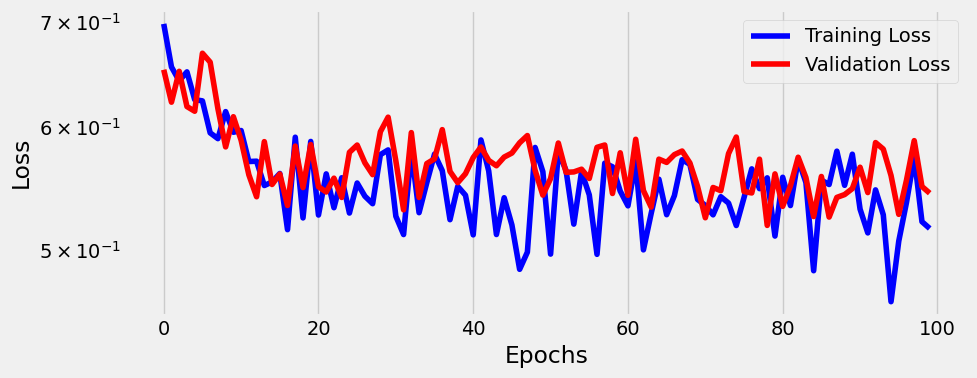

In [192]:
fig = sbs_logistic.plot_losses()

La conclusión que sacamos después de ver el gráfico anterior es que es horrible, porque parece que nuestro modelo apenas aprende nada.

Tal vez un modelo más profundo pueda hacerlo mejor.

### Modelo más profundo

Para construir nuestro modelo más profundo, vamos a añadir no una, sino dos capas ocultas a nuestro modelo y hacerlo más profundo. Todavía empezamos con una capa de aplanamiento, y la última parte de nuestro modelo sigue siendo una Sigmoide, pero hay dos capas Lineales antes de la capa de salida ya existente.

La forma esquemática se este modelo seria la siguiente

![Modelo tres capas](figuras/ModeloTresCapas.PNG)

Respecto de la nomenclatura de la figura anterior, los subíndices de w y z representan los índices (de base cero) para la capa y la unidad: en la capa de salida. Asi por ejemplo, w20 representa los pesos correspondientes a la
primera unidad (#0) de la tercera capa (#2).

En este gráfico qué estamos representando? Vamos a resolver el paso hacia adelante(forward pass) , es decir
el camino de las entradas (x) a la salida (y):

1.- Una imagen se aplana a un tensor con 25 características o features, de x0 a x24 (no representado en la figura anterior)

2.- Las 25 características se envían a cada una de las cinco unidades de capa oculta #0

3.- Cada unidad de la capa oculta #0 utiliza sus pesos, de w00 a w04, y las características de la capa de entrada para calcular sus salidas correspondientes, de z00 a z04.

4.- Las salidas de la capa oculta #0 se envían a cada una de las tres unidades de la capa oculta nº 1 (en cierto modo, las salidas de Capa Oculta #0 funcionan como si fueran características de la Capa Oculta Layer #1).

5.- cada unidad de la capa oculta nº 1 utiliza sus pesos, de w10 a w12 y los valores z0 de la capa oculta anterior para calcular sus salidas correspondientes, de z10 a z12.

6.- Las salidas de la capa oculta nº 1 se envían a  la capa de salida (de nuevo, las salidas de la capa oculta nº 1 funcionan como si fueran características de la capa de salida).

7.- La unidad de la capa de salida utiliza sus pesos (w20) y los valores z1 de la capa oculta anterior para calcular su
salida correspondiente (z2).

8.- z2 es un logit, que se convierte en una probabilidad utilizando una función sigmoidea.


Hay un par de cosas a destacar:

* Todas las unidades de las capas ocultas, y la de la capa de salida, toman un conjunto de entradas (x o z) y realizan la misma operación (wTx o wTz, cada una utilizando sus propios pesos, por supuesto), produciendo una salida (z).

* En las capas ocultas, estas operaciones son exactamente como los modelos de regresión logística que hemos utilizado hasta ahora, modelos en que la regresión logística produjo un logit.

* Es perfectamente correcto pensar en las salidas de una capa como características de la siguiente capa; de hecho, esto es el núcleo de la técnica de que veremos en un capítulo posterior.

DE acuerdo con todo esto, el modelo que vamos a emplear se construye de la siguiente manera,

In [193]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_nn = nn.Sequential()
model_nn.add_module('flatten', nn.Flatten())
model_nn.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_nn.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_nn.add_module('output', nn.Linear(3, 1, bias=False))
model_nn.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters 
optimizer_nn = optim.SGD(model_nn.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

Ahora entrenamos el modelo

In [194]:
n_epochs = 100

sbs_nn = StepByStep(model_nn, binary_loss_fn, optimizer_nn)
sbs_nn.set_loaders(train_loader, val_loader)
sbs_nn.train(n_epochs)

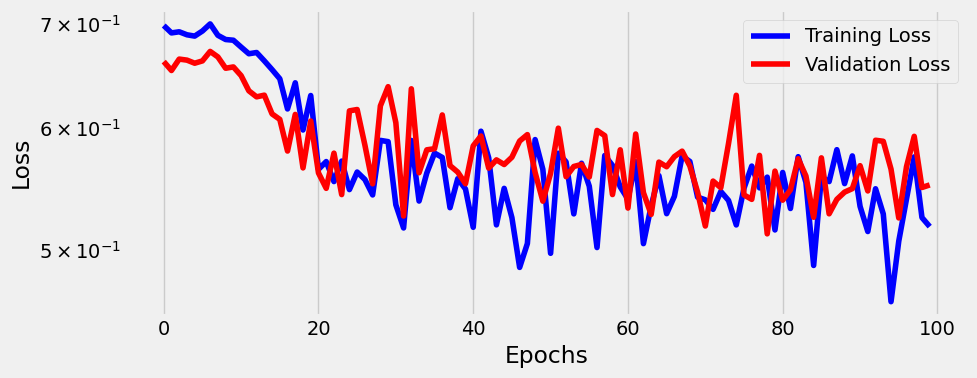

In [195]:
fig = sbs_nn.plot_losses()

Como podemos observar con este modelo tampoco podemos mejorar sustancialmente la función de pérdida. No hemos mejorado nada. Lo que está ocurriendo es que no hemos metido en el modelo ninguna función de activación.

```{index} Función de activación.
```

Una **función de activación** es una función no lineal que transforma las salidas de las capas ocultas, de forma similar a la función sigmoidea que transforma los logits en la capa de salida. 

En realidad, la sigmoide es una de las muchas funciones de activación. Hay otras, como la hiperbólica-tangente (tanh) y la Rectified Linear Unit (ReLU).

Un modelo más profundo sin funciones de activación en sus capas ocultas no es mejor que una regresión lineal o logística. Eso es lo que quería ilustrar con los dos modelos que hemos entrenado, el superficial y el profundo. Por eso he eliminado el sesgo en ambos modelos también: hace que la comparación sea más directa.


### El modelo matemático subyacente.

Desarrollamos este apartado por si tienes curiosidad por entender, usando multiplicación de matrices, por qué nuestro modelo profundo es equivalente a una regresión logística, para ello comprueba la secuencia de ecuaciones que aparece a continuación.

En las expresiones matemáticas que siguen, cada fila corresponde a una capa. Los datos fluyen de derecha a izquierda (ya que así es como se multiplicar una secuencia de matrices), empezando por las 25 características a la
 derecha y terminando con un único resultado logit a la izquierda.
 
Si se observa cada capa (fila) por separado, también debería quedar claro que las salidas de una capa determinada (el vector más a la izquierda de cada fila) son las de la siguiente capa, del mismo modo que las características son las entradas de la primera capa.


$$
\large
\begin{array}{rcccccccccccc}
\text{Hidden}\ \#0 & & & & & & & &
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
&
=
&
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}
&
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
\text{Hidden}\ \#1 & & & &
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
&
=
&
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}
&
&
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
\\
\text{Output} &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}
&
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
\\
\hline
\text{substituyendo } z's... &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underbrace{
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}}_{\text{Output Layer}}
&
& &
\underbrace{
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}}_{\text{Hidden Layer #1}}
& &
& &
\underbrace{
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}}_{\text{Hidden Layer #0}}
&
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
\text{multiplicando...} & &
=
&
\underbrace{
\underset{(1 \times 25)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}}_{\text{Matrices Multiplicadas}}
&
& & & & & & & &
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\end{array}
$$



De acuerdo con estos resultados, **se puede concluir que un modelo con cualquier número de capas ocultas tiene un
modelo equivalente al de sin capas ocultas**. Claro, no incluimos el sesgo aquí porque haría mucho más difícil ilustrar este
punto. Por este motivo los gráficos que hemos obtenido en nuestro ejemplo mostrado más arriba, los resultados de la función de pérdida eran muy similares.

Si las ecuaciones matriciales mostradas más arriba no fueran suficientes para ver esto, vamos a intentarlo usando algo de código. 

```{index} obtención de pesos
```

En primer lugar, tenemos que obtener los pesos para las capas en nuestro modelo profundo. Podemos usar el atributo de peso de cada capa, *sin olvidar separarlo() del gráfico de cálculo*, para que así lo podamos usarl libremente en otras operaciones.

In [196]:
w_nn_hidden0 = model_nn.hidden0.weight.detach()
w_nn_hidden1 = model_nn.hidden1.weight.detach()
w_nn_output = model_nn.output.weight.detach()

w_nn_hidden0.shape, w_nn_hidden1.shape, w_nn_output.shape

(torch.Size([5, 25]), torch.Size([3, 5]), torch.Size([1, 3]))

Las dimensiones deben coincidir tanto con la definición de nuestro modelo como con las matrices de peso en las ecuaciones definidas anteriormente.

Podemos calcular la fila inferior, es decir, el modelo equivalente utilizando la multiplicación de matrices (que se realiza de derecha a izquierda, como en las ecuaciones):

NOTA: La multiplicación de matrices se hace mediante el símbolo @.

In [197]:
w_nn_equiv = w_nn_output @ w_nn_hidden1 @ w_nn_hidden0
w_nn_equiv.shape

torch.Size([1, 25])

A continuación, tenemos que compararlos con las ponderaciones del modelo superficial, es decir, la regresión logística:

In [198]:
w_logistic_output = model_logistic.output.weight.detach()
w_logistic_output.shape

torch.Size([1, 25])

La misma dimensión, como se esperaba. Si comparamos los valores, uno por uno, encontraremos que son similares, pero no exactamente iguales. Intentemos de comprender el cuadro completo observando la imagen siguiente:

![Comparación de modelos](figuras/ComparacionModelo.PNG)

A la izquierda, representamos los 25 pesos/parámetros de ambos modelos. Aunque no son exactamente iguales, la similitud es sorprendente.

A la derecha, podemos apreciar que las ponderaciones están, efectivamente, muy correlacionadas.

Es bastante sencillo saber que el modelo de regresión logística de una sola capa tenga 25 ponderaciones. Pero, ¿cuántas ponderaciones tiene el modelo de profundidad, el segundo modelo? Podemos calcularlo: 25 características por cinco unidades en la capa oculta #0:(125), más esas cinco unidades por tres unidades en la capa oculta nº 1 (15),más los tres últimos pesos de la capa oculta nº 1 a la capa de salida de salida, sumando un total de 143 ponderaciones.

O simplemente podríamos usar la propiedad *numel* de PyTorch para devolver el número total de elementos de elementos, que en este caso será  un tensor.Para conseguir estos creamos la siguiente función y se lo añadimos a la clase *StepByStep*.

In [199]:
def count_parameters(self):
    return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

# Lo añadimos como método a la clase StepByStep
setattr(StepByStep, 'count_parameters', count_parameters)

Como hemos dicho, se ha agregado como un método de nuestra clase *StepByStep*, y tomemos sólo los tensores que requieren gradiente, de modo que sólo contemos con los pesos que necesitan ser actualizados. Ahora mismo, son todos, claro, pero no necesariamente siempre será así y entonces no hará falta hacer esta distinción porque se utilizará  el aprendizaje por transferencia que se verá en un capítulo posterior.

Hacemos este cómputo con el nuevo método

In [200]:
sbs_logistic.count_parameters(), sbs_nn.count_parameters()


(25, 143)

### Pesos como pixeles.

Durante la preparación de los datos, aplanamos las entradas de imágenes de cinco por cinco a tensores de 25 elementos. He aquí una idea descabellada: ¿qué pasa si si tomamos algún otro tensor con 25 elementos e intentamos visualizarlo
como una imagen?.

Tenemos algunos candidatos perfectos para esto: los pesos utilizados por cada unidad en la capa oculta #0. Cada unidad utiliza 25 pesos ya que cada unidad recibe valores de 25 características. Incluso tenemos estos pesos en una variable:

In [201]:
w_nn_hidden0.shape

torch.Size([5, 25])

Cinco unidades, 25 pesos cada una. Perfecto. Sólo tenemos que usar la vista para convertir los tensores largos de 25 elementos que representan los pesos en tensores bidimensionales (5x5), y visualizarlos como si fueran imágenes:

In [202]:
def figure7(weights):
    fig, axs = plt.subplots(1, 5, figsize=(15, 4))

    for i, m in enumerate(weights):
        axs[i].imshow(m.reshape(-1, 5).tolist(), cmap='gray')
        axs[i].grid(False)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(r'$w_{0' + str(i) + '}$')

    fig.suptitle('Hidden Layer #0')
    fig.subplots_adjust(top=0.6) 
    fig.tight_layout()
    return fig

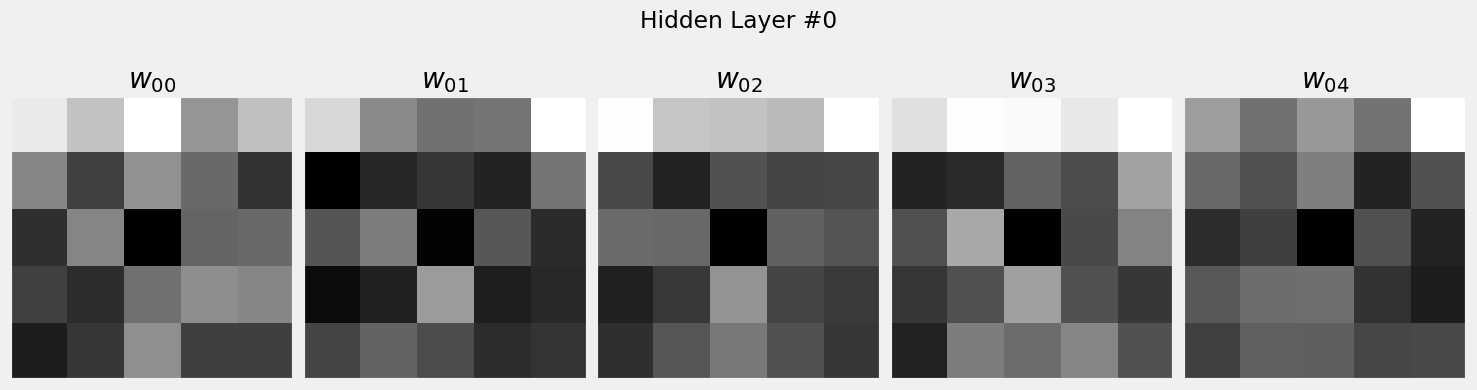

In [203]:
fig = figure7(w_nn_hidden0)

La visualización de los pesos en forma de imágenes es habitual cuando se utilizan redes neuronales convolucionales (CNN). Estas imágenes serán llamadas filtros, y los modelos entrenados probablemente exhibirán características reconocibles en sus filtros. 

Como nuestro modelo estaba mal entrenado, no es de extrañar que las imágenes de arriba no sean muy informativas. Además, en nuestro caso, no son del todo "filtros", ya que tienen el mismo tamaño que la imagen de entrada. En los modelos basados en CNN los filtros reales sólo cubren una parte de la imagen. Volveremos a ello en un capítulo posterior.

# Funciones de activación.

```{index} Funciones de activación
```

Las **funciones de activación** son funciones no lineales. O bien aplastan o doblan las líneas rectas. Rompen la equivalencia entre el modelo profundo y el superficial.

Pytorch cuenta con un buen conjunto de <a href="https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity" target="_blank"> funciones de activación </a>, pero aquí nos vamos a central en las que se utilizan de una forma más frecuente.

## Función sigmoidea

Comencemos con la más tradicional de las funciones de activación, la sigmoidea, que ya hemos utilizado para transformar logits en probabilidades. Hoy en día, ese es prácticamente su único uso, pero en los primeros tiempos de las redes neuronales, se encontraba en todas partes.

$$
\Large \sigma(z) = \frac{1}{1 + e^{-z}}
$$

In [204]:
def plot_activation(func, name=None):
    z = torch.linspace(-5, 5, 1000)
    z.requires_grad_(True)
    func(z).sum().backward()
    sig = func(z).detach()

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    if name is None:
        try:
            name = func.__name__
        except AttributeError:
            name = ''

    if name == 'sigmoid':
        ax.set_ylim([0, 1.1])
    elif name == 'tanh':
        ax.set_ylim([-1.1, 1.1])
    elif name == 'relu':
        ax.set_ylim([-.1, 5.01])
    else:
        ax.set_ylim([-1.1, 5.01])
        
    ax.set_xticks(np.arange(-5, 6, 1))
    ax.set_xlabel('z')
    ax.set_ylabel(r'$\sigma(z)$')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_title(name, fontsize=16)
    ax.plot(z.detach().numpy(), sig.numpy(), c='k', label='Activation')
    ax.plot(z.detach().numpy(), z.grad.numpy(), c='r', label='Gradient')
    ax.legend(loc=2)

    fig.tight_layout()
    fig.show()
    return fig

C:\Users\Francisco\AppData\Local\Temp\ipykernel_21084\1908806294.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


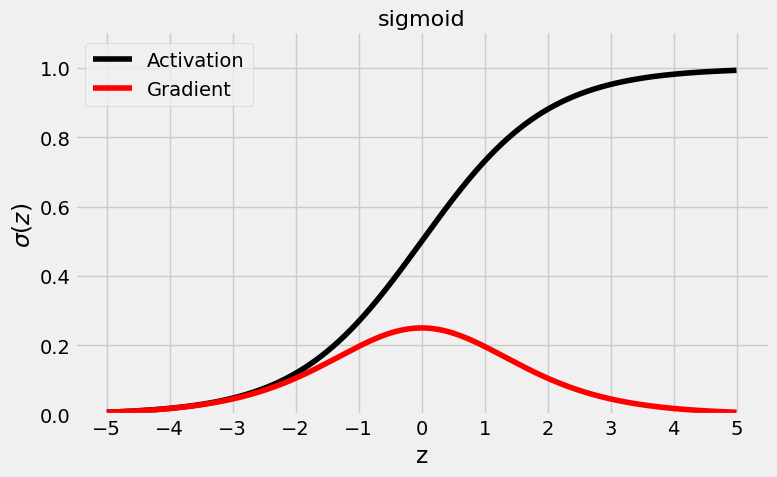

In [205]:
fig = plot_activation(torch.sigmoid)

Recapitulemos rápidamente la forma de una sigmoide: como puede ver en la figura anterior, una función de activación sigmoidea "aplasta" sus valores de entrada de entrada (z) en el rango (0, 1) (el mismo rango pueden tomar las probabilidades, la razón por la que se utiliza en la capa de salida para tareas de clasificación binaria
binaria). También se puede comprobar que **el valor de su pico de gradiente es sólo 0,25** (para z = 0) y que se acerca ya a cero a medida que el valor absoluto de z alcanza un valor de cinco.

Además, recuerde que los valores de activación de cualquier capa son las entradas de la capa siguiente y, dado el rango del sigmoide los valores de activación van a estar centrados alrededor de 0,5, en lugar de de cero. Esto significa que, aunque normalicemos nuestras entradas para alimentar la primera capa, ya no será así para las demás capas.

En los capítulos anteriores, estandarizamos las características (media cero, desviación estándar) para mejorar el rendimiento del descenso gradiente. El mismo razonamiento se aplica aquí, ya que las salidas de cualquier de cualquier capa son las entradas de la capa siguiente. En realidad hay más, y tocaremos brevemente este tema de nuevo en la función de activación ReLU.

PyTorch tiene la función sigmoide disponible de dos formas posibles: *torch.sigmoide y nn.Sigmoide*. La primera
es una función simple, y la segunda es una clase completa heredada de nn.Module, siendo así, a todos los efectos, un
modelo en sí mismo.

In [206]:
dummy_z = torch.tensor([-3., 0., 3.])
torch.sigmoid(dummy_z)

tensor([0.0474, 0.5000, 0.9526])

In [207]:
nn.Sigmoid()(dummy_z)

tensor([0.0474, 0.5000, 0.9526])

## Tangente hiperbólica (TanH).

```{index} Tangente hiperbólica
```

La función de activación **tangente hiperbólica** es la evolución de la sigmoidea, ya que sus salidas son valores con media cero, a diferencia de su predecesora.

$$
\Large \sigma(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}
$$

C:\Users\Francisco\AppData\Local\Temp\ipykernel_21084\1908806294.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


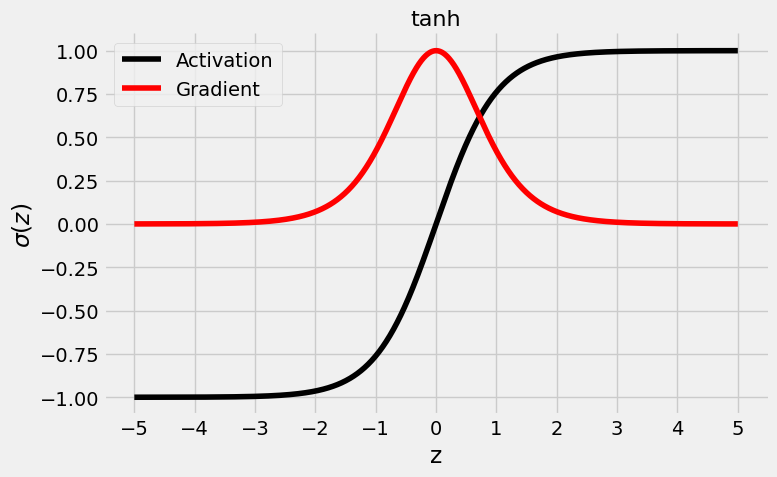

In [208]:
fig = plot_activation(torch.tanh)

Como puede ver en la figura anterior, la función de activación tanh "aplasta" los valores de entrada en el rango (-1, 1). Por lo tanto, al estar centrados en cero, los valores de activación ya están (en cierto modo)  normalizadas para la siguiente capa, lo que hace que la tangente hiperbólica una mejor función de activación que la sigmoidea.

En cuanto al gradiente, tiene un valor máximo mucho mayor de 1,0 (de nuevo, para z = 0), pero su disminución es aún más rápida, acercándose a cero a valores absolutos de z tan bajos como tres. Esta es la causa subyacente de lo que se denomina el *problema de los gradientes de fuga*, que hace que el entrenamiento de la red sea progresivamente más lento.

En PyTorch se puede obtener de la siguiente manera

In [209]:
dummy_z = torch.tensor([-3., 0., 3.])
torch.tanh(dummy_z)

tensor([-0.9951,  0.0000,  0.9951])

In [210]:
nn.Tanh()(dummy_z)

tensor([-0.9951,  0.0000,  0.9951])

## Rectified Linear Unit (ReLU)

```{index} Rectified Linear Unit, ReLU, neurona muerta
```

Tal vez "aplastar" no sea el camino a seguir... ¿y si doblamos un poco las reglas y utilizamos una función de activación que  doble la línea? La ReLU nació así y dio lugar a toda una familia de funciones similares.

La ReLU, o una de sus parientes, es la función de activación más común hoy en día. Se trata de una función de activación que resuelve el problema de la desaparición de los gradientes de las variables y también es la más rápida para calcular los gradientes.

$$
\Large
\begin{aligned}
\sigma(z) &=
\begin{cases}
z,\ \text{if } z \ge 0
\\
0,\ \text{if } z < 0
\end{cases}
\\
& \text{or}
\\
\sigma(z) &= \text{max}(0, z)
\end{aligned}
$$

C:\Users\Francisco\AppData\Local\Temp\ipykernel_21084\1908806294.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


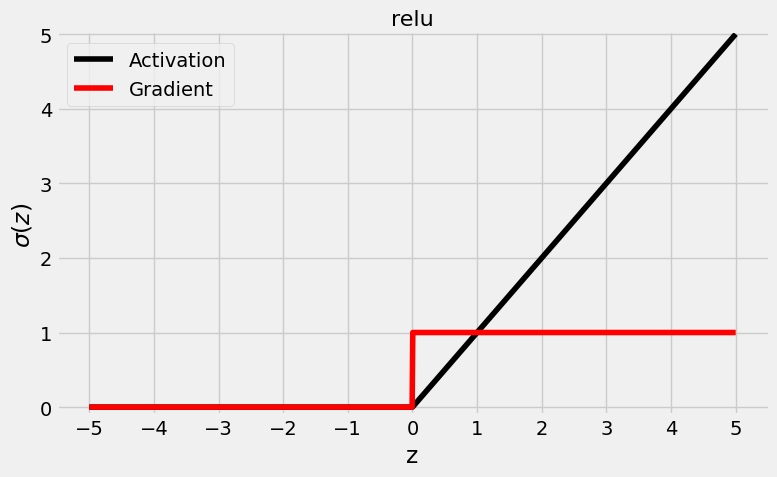

In [211]:
fig = plot_activation(torch.relu)

Como puede ver en la figura anterior, la función ReLU es totalmente diferente a las que hemos visto anteriormente: no "aplasta" los valores en un rango, simplemente preserva los valores positivos y convierte todos los valores negativos en cero.

La ventaja de utilizar una ReLU es que su gradiente es uno (para valores positivos) o cero (para valores negativos) - ¡no más gradientes gradientes que se desvanecen. Este patrón conduce a una convergencia más rápida de la red. 

Por otro lado, este comportamiento también puede conducir a lo que se denomina una **"neurona muerta"**, es decir, una neurona cuyas entradas son son sistemáticamente negativas y, por tanto, siempre tiene un valor de activación  de cero. Peor aún, el gradiente también es cero para las entradas negativas, lo que significa que los pesos no se actualizan. Es como si la neurona se hubiera atascado.

Los valores de activación de la ReLU no están centrados obviamente en cero. ¿Es peor que la tangente hiperbólica? Seguramente no, de lo contrario no se habría convertido en una función de activación tan popular entre los profesionales. 

La ReLU, al tener sus gradientes comparativamente mayores, es capaz de lograr resultados mejores y más rápidos que las otras dos funciones de activación a pesar de que sus salidas no estén centradas en cero.

En PyTorch hay tres caminos para obtener esta función de activación

In [212]:
dummy_z = torch.tensor([-3., 0., 3.])
F.relu(dummy_z)

tensor([0., 0., 3.])

In [213]:
nn.ReLU()(dummy_z)

tensor([0., 0., 3.])

In [214]:
dummy_z.clamp(min=0)

tensor([0., 0., 3.])

## Leaky ReLU

```{index} Leaky ReLU
```

¿Cómo se puede dar a una "neurona muerta" la oportunidad de volver a la vida? Si el problema subyacente es el hecho de que se ha atascado, tenemos que dar un pequeño empujón. Y eso es lo que hace una ReLU con fugas (ReLU Leaky): para entradas negativas, devuelve un pequeño valor de activación y gradiente, en lugar de un cero fijo para ambos. El multiplicador para
valores negativos, 0,01, se llama *coeficiente de fuga*.

Puede que no sea mucho, pero da a la neurona la oportunidad de despegarse, y mantiene las buenas propiedades de la ReLU: mayores gradientes y una convergencia más rápida.

$$
\Large
\begin{aligned}
\sigma(z) =&
\begin{cases}
z,\ \text{if } z \ge 0
\\
0.01z,\ \text{if } z < 0
\end{cases}
\\
\text{or}&
\\
\sigma(z)=&\text{max}(0,z)+0.01\ \text{min}(0,z)
\end{aligned}
$$



C:\Users\Francisco\AppData\Local\Temp\ipykernel_21084\1908806294.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


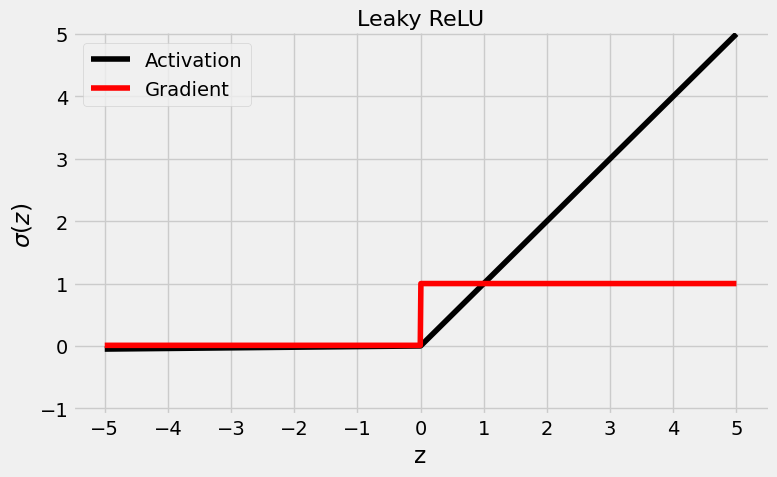

In [215]:
fig = plot_activation(nn.LeakyReLU(), name='Leaky ReLU')

Su valor se puede conseguir de las siguientes formas

In [216]:
dummy_z = torch.tensor([-3., 0., 3.])
F.leaky_relu(dummy_z, negative_slope=0.01)

tensor([-0.0300,  0.0000,  3.0000])

In [217]:
nn.LeakyReLU(negative_slope=0.02)(dummy_z)

tensor([-0.0600,  0.0000,  3.0000])

## Parametric ReLU (PReLU)

```{index} Parametric ReLU, PReLU
```

La función de activación denominada *ReLU paramétrica* es la evolución natural del ReLU con fugas: en lugar de elegir arbitrariamente un coeficiente de fuga (como 0,01), hagamos que sea un parámetro (a). Con suerte, el modelo aprenderá
cómo evitar las neuronas muertas, o cómo devolverlas a la vida. Esta función se podría decir que, es una solución ingeniosa al problema.

$$
\Large
\begin{aligned}
\sigma(z) =&
\begin{cases}
z,\ \text{if } z \ge 0
\\
az,\ \text{if } z < 0
\end{cases}
\\
\text{or}&
\\
\sigma(z)=&\text{max}(0,z)+a\ \text{min}(0,z)
\end{aligned}
$$

C:\Users\Francisco\AppData\Local\Temp\ipykernel_21084\1908806294.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


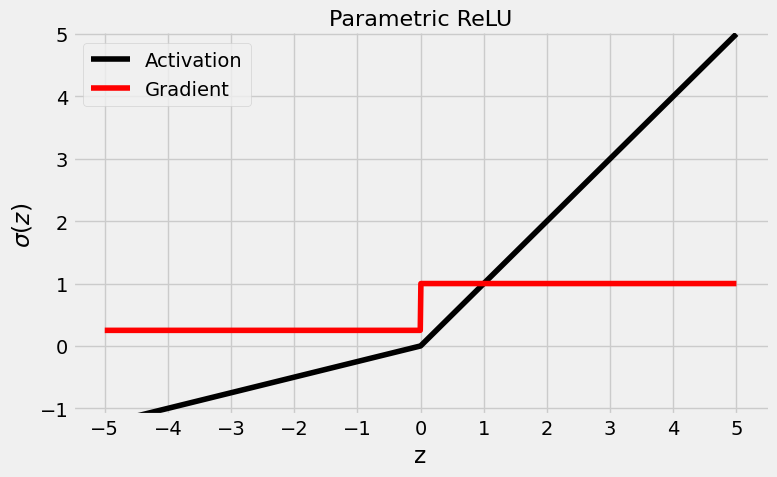

In [218]:
fig = plot_activation(nn.PReLU(), name='Parametric ReLU')

Como se puede ver en la figura anterior, la pendiente del lado izquierdo es mucho mayor ahora, 0,25 para ser precisos, el valor por defecto de PyTorch para el parámetro a. Su valor se puede conseguir de la siguiente forma en PyTorch

In [219]:
dummy_z = torch.tensor([-3., 0., 3.])
F.prelu(dummy_z, weight=torch.tensor(0.25))

tensor([-0.7500,  0.0000,  3.0000])

In [220]:
nn.PReLU(init=0.25)(dummy_z)

tensor([-0.7500,  0.0000,  3.0000], grad_fn=<PreluBackward0>)

# Modelo de aprendizaje.

Ahora que hemos aprendido que las funciones de activación rompen la equivalencia con un modelo superficial, vamos a utilizarlas para transformar nuestro modelo profundo en otro modelo profundo, pero que resuelve mejor el problema. Tiene la misma arquitectura que el modelo anterior, excepto por la incorporación de las funciones de activación aplicadas a las salidas de las capas ocultas. Este es el diagrama del modelo actualizado:

![Modelo con Función Activación](figuras/ModeloConFuncionActivacion.PNG)

A continuación mostramos el código necesario para implementar ese modelo

In [221]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

Entrenamos el modelo

In [222]:
n_epochs = 50

sbs_relu = StepByStep(model_relu, binary_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)

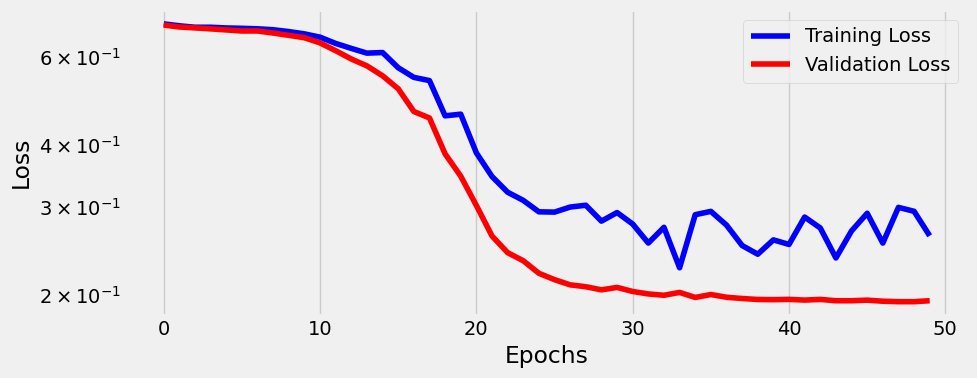

In [223]:
fig = sbs_relu.plot_losses()

Esto está mucho mejor. Pero, para comprender realmente la diferencia que suponen las funciones de activación, vamos a trazar todos los modelos en el mismo gráfico:

![Todos gráficos](figuras/DosGraficos.PNG)

Nuestro último nuevo modelo sólo necesitó una pequeña cantidad de iteraciones  para superar al anterior.Claramente, este modelo no es equivalente a una regresión logística: es mucho mejor.

No obstante aunque se mejora el resultado, ambos modelos son un poco cutres pues su rendimiento es bastante pobre si se observan sus precisiones (que oscilan entre el 43% y el 65% para el conjunto de validación). El único propósito de este
ejercicio es demostrar que las funciones de activación, rompiendo la equivalencia con una regresión logística, son capaces de lograr mejores resultados en la minimización de la función de  pérdidas.

Este último modelo en particular también presenta una pérdida de validación menor que la pérdida de entrenamiento, que no es lo que generalmente se espera. Ya hemos  un caso como éste en un capítulo anterior: el conjunto de validación era más fácil que que el conjunto de entrenamiento. El ejemplo actual es un poco más matizado que que eso... aquí está la explicación.

En primer lugar, nuestro modelo no es tan bueno y tiene tendencia a predecir más puntos en la clase positiva (FPR y TPR altos);

En segundo lugar, uno de los mini lotes del conjunto de validación tiene casi todos sus puntos en la clase positiva, por lo que la pérdida es muy baja; en tercer lugar sólo hay cuatro minilotes en el conjunto de validación, por lo que la
pérdida media se ve fácilmente afectada por un solo minilote.

Es hora de hacerse dos preguntas:

* ¿por qué se rompe la equivalencia con una regresión logística?

* ¿qué hacen exactamente las funciones de activación bajo el capó?

La primera pregunta la respondemos en el siguiente apartado utilizando para ello las fórmulas matemáticas que hay debajo de este modelo. La segunda pregunta se responderá en un capítulo posterior.

## Formulación matemática del problema.

$$
\large
\begin{array}{rcccccccccccc}
\text{Hidden }\#0 & & & & & & & &
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
&
=
&
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}
&
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
\text{Hidden }\#1 & & & &
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
&
=
&
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}
&
&
\underbrace{
f_0
\underset{(5 \times 1)}{
\left(
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}
\right)}}_{\text{Activation #0}}
\\
\text{Output} &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}
&
\underbrace{
f_1
\underset{(3 \times 1)}{
\left(
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}
\right)}}_{\text{Activation #1}}
\\
\hline
\text{substituting z's...} &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underbrace{
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}}_{\text{Output Layer}}
&
f_1
& &
\left(
\underbrace{
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}}_{\text{Hidden Layer #1}}
\right.
&
&
f_0
& &
\left(
\underbrace{
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}}_{\text{Hidden Layer #0}}
\right.
&
&
\left.
\left.
\underbrace{
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}}_{\text{Inputs}}
\right)
\right)
\end{array}
$$

Como antes, los datos fluyen de derecha a izquierda (ya que así es como se multiplicar una secuencia de matrices), empezando por las 25 características a la la derecha y terminando con una única salida logit a la izquierda.

Si se observa cada capa (fila) por separado, también debería quedar claro que las salidas de una capa determinada (el vector más a la izquierda de la fila) son transformadas por una función de activación antes de convertirse en entradas
de la siguiente capa.

La fila que está debajo de la línea muestra el resultado de componer todas las operaciones por encima de la línea. No hay forma de simplificar más la expresión debido a la existencia de las dos funciones de activación (f0 y f1). En efecto, rompen la equivalencia con una regresión logística.

Si ponemos todo el código final obtenido en este capítulo nos quedará lo siguiente

In [224]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

In [225]:
def index_splitter(n, splits, seed=13):
    idx = torch.arange(n)
    # Makes the split argument a tensor
    splits_tensor = torch.as_tensor(splits)
    # Finds the correct multiplier, so we don't have
    # to worry about summing up to N (or one)
    multiplier = n / splits_tensor.sum()    
    splits_tensor = (multiplier * splits_tensor).long()
    # If there is a difference, throws at the first split
    # so random_split does not complain
    diff = n - splits_tensor.sum()
    splits_tensor[0] += diff
    # Uses PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

In [226]:
def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

In [227]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Builds different composers because of data augmentation on training set
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [228]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(11)
# Now we can create a model
model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

In [229]:
n_epochs = 50

sbs_relu = StepByStep(model_relu, binary_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)